In [9]:
import panel as pn
import param
import geopandas as gpd
import pandas as pd
import shapely.wkt
import networkx as nx
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

pn.extension('plotly')

## Grafo de conexion entre barrios

In [14]:
def safe_load_geometry(wkt_str):
    try:
        return shapely.wkt.loads(wkt_str)
    except Exception:
        return None

class BusGraphPanel(param.Parameterized):
    barrio = param.ObjectSelector(default=None, objects=[])

    def __init__(self, **params):
        super().__init__(**params)

        # Cargar datos
        self.barrios_gdf = gpd.read_file('data/barris.geojson')
        bus_lines_df = pd.read_csv("data/linies_bus.csv")
        bus_lines_df["geometry"] = bus_lines_df["GEOMETRY"].apply(safe_load_geometry)
        self.bus_lines_gdf = gpd.GeoDataFrame(bus_lines_df, geometry="geometry", crs="EPSG:4326")

        # Crear grafo
        self.G = nx.Graph()
        for idx, row in self.barrios_gdf.iterrows():
            self.G.add_node(row["NOM"], geometry=row.geometry)

        for line in self.bus_lines_gdf.itertuples():
            if not line.geometry:
                continue
            touched_barrios = set()
            for idx, barrio in self.barrios_gdf.iterrows():
                if line.geometry.intersects(barrio.geometry):
                    touched_barrios.add(barrio["NOM"])
            touched_barrios = list(touched_barrios)
            for i in range(len(touched_barrios)):
                for j in range(i + 1, len(touched_barrios)):
                    b1, b2 = touched_barrios[i], touched_barrios[j]
                    if self.G.has_edge(b1, b2):
                        self.G[b1][b2]["weight"] += 1
                    else:
                        self.G.add_edge(b1, b2, weight=1)

        # Posiciones
        self.pos = {node: (geom.centroid.x, geom.centroid.y)
                    for node, geom in nx.get_node_attributes(self.G, 'geometry').items()}
        nx.set_node_attributes(self.G, self.pos, 'pos')

        self.node_data = [{'id': n, 'x': x, 'y': y} for n, (x, y) in self.pos.items()]
        self.param.barrio.objects = [n['id'] for n in self.node_data]

    @param.depends('barrio')
    def view(self):
        if self.barrio is None:
            return pn.pane.Markdown("**Selecciona un barrio**")

        # Vecinos directos del barrio seleccionado
        vecinos = set(self.G.neighbors(self.barrio))
        conectados = [self.barrio] + list(vecinos)
        no_conectados = [n for n in self.G.nodes() if n not in conectados]

        # Trazas de aristas (igual que antes)
        edge_traces = []
        for u, v, data in self.G.edges(data=True):
            x0, y0 = self.G.nodes[u]['pos']
            x1, y1 = self.G.nodes[v]['pos']
            sel = self.barrio in (u, v)
            edge_traces.append(go.Scatter(
                x=[x0, x1, None],
                y=[y0, y1, None],
                mode='lines',
                line=dict(width=data['weight'],
                          color='red' if sel else 'lightgray'),
                opacity=1.0 if sel else 0.2,
                hoverinfo='text',
                text=[f"{u} ↔ {v}: {data['weight']} líneas"] * 3,
                showlegend=False
            ))

        # Traza de nodos conectados (barrio + vecinos)
        xs_c = [self.pos[n][0] for n in conectados]
        ys_c = [self.pos[n][1] for n in conectados]
        txt_c = conectados
        colors_c = ['black' if n == self.barrio else 'blue' for n in conectados]
        connected_trace = go.Scatter(
            x=xs_c, y=ys_c,
            mode='markers+text',
            text=txt_c,
            textposition="top center",
            hoverinfo='text',
            marker=dict(size=10, color=colors_c, line_width=2),
            opacity=1.0,
            textfont=dict(color=colors_c),
            showlegend=False
        )

        # Traza de nodos NO CONECTADOS (gris, semitransparentes)
        xs_nc = [self.pos[n][0] for n in no_conectados]
        ys_nc = [self.pos[n][1] for n in no_conectados]
        txt_nc = no_conectados
        disconnected_trace = go.Scatter(
            x=xs_nc, y=ys_nc,
            mode='markers+text',
            text=txt_nc,
            textposition="top center",
            hoverinfo='text',
            marker=dict(size=10, color='lightgray', line_width=2),
            opacity=0.2,
            textfont=dict(color='lightgray'),
            showlegend=False
        )

        # Creamos la figura
        fig = go.Figure(data=edge_traces + [disconnected_trace, connected_trace])
        fig.update_layout(
            title=f"Conexiones de '{self.barrio}'",
            margin=dict(b=20, l=5, r=5, t=40),
            hovermode='closest',
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            width=1400,
            height=700
        )

        return pn.pane.Plotly(
            fig,
            config={'responsive': False},
            sizing_mode='fixed',
            width=1400,
            height=700
        )



# Función para usar como tab en el dashboard
def crear_tab_conexiones_bus():
    app = BusGraphPanel()

    # Selector de barrio (fijo)
    controles = pn.WidgetBox(
        pn.pane.Markdown("## Barrio"),
        app.param.barrio,
        width=300,
        sizing_mode='fixed'
    )
    controles.flex = 0

    # Pane reactivo
    grafico_pane = pn.panel(
        app.view,              
        sizing_mode='fixed',     # fijo
        width=1400,
        height=700,
        config={'responsive': False}
    )
    # Siempre ocupa 700px
    grafico_pane.flex = 0

    # Fila con selector y gráfico
    fila = pn.Row(
        controles,
        grafico_pane,
        sizing_mode='stretch_width'
    )

    # Columna contenedora de la pestaña
    return pn.Column(
        pn.pane.Markdown("## Conexiones entre barrios por líneas de bus"),
        fila,
        sizing_mode='stretch_width'
    )


/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_62034/2544445400.py:9: UserWarning:

Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.



## Air Quality

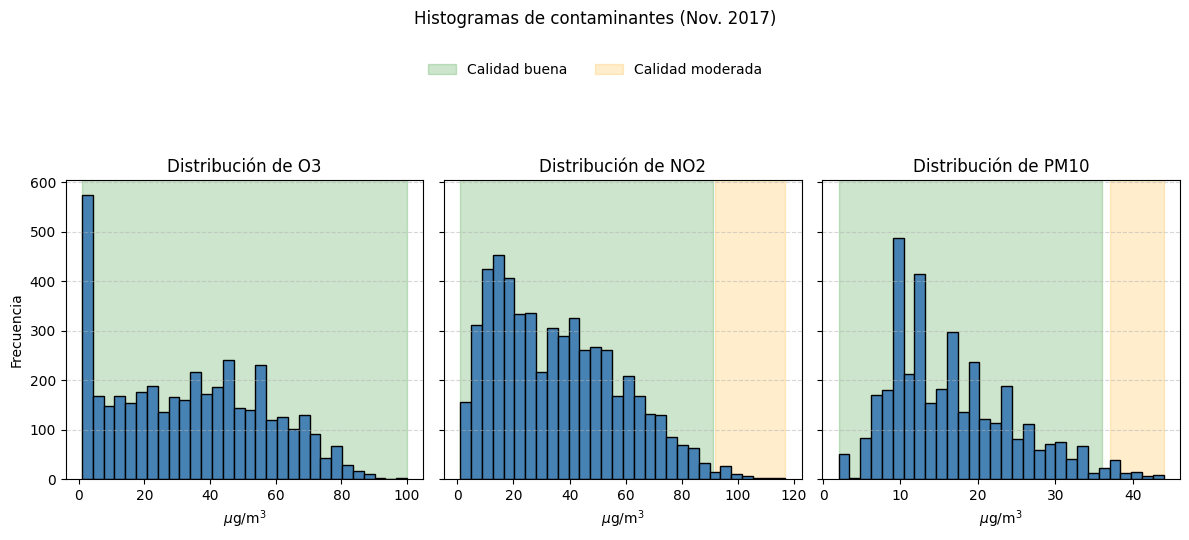

In [ ]:
# Carga datos de calidad del aire
df = pd.read_csv("data/air_quality_Nov2017.csv")

# Conversión de columnas a numérico
for col in ["O3 Value", "NO2 Value", "PM10 Value"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Función única que genera las tres gráficas como subplots
def plot_all_histograms(df):
    contaminants = [
        ("O3 Value", "O3 Quality", "Distribución de O3"),
        ("NO2 Value", "NO2 Quality", "Distribución de NO2"),
        ("PM10 Value", "PM10 Quality", "Distribución de PM10")
    ]

    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
    
    # Parches para la leyenda
    patch_good = mpatches.Patch(color='green', alpha=0.2, label='Calidad buena')
    patch_mod  = mpatches.Patch(color='orange', alpha=0.2, label='Calidad moderada')

    for ax, (value_col, quality_col, title) in zip(axes, contaminants):
        data = df[value_col].dropna()
        ax.hist(data, bins=30, color='steelblue', edgecolor='black')
        
        # Sombras para calidad
        good = df[df[quality_col] == "Good"][value_col].dropna()
        mod  = df[df[quality_col] == "Moderate"][value_col].dropna()
        
        if not good.empty:
            ax.axvspan(good.min(), good.max(), color='green', alpha=0.2, zorder=0)
        if not mod.empty:
            ax.axvspan(mod.min(), mod.max(), color='orange', alpha=0.2, zorder=0)
        
        ax.set_title(title)
        ax.set_xlabel(r'$\mu\mathrm{g}/\mathrm{m}^3$')
        ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    axes[0].set_ylabel("Frecuencia")
    
    # Leyenda global en la parte superior
    fig.legend(handles=[patch_good, patch_mod],
               loc='upper center',
               ncol=2,
               frameon=False,
               bbox_to_anchor=(0.5, 1.02))
    
    # Título
    fig.suptitle("Histogramas de contaminantes (Nov. 2017)", y=1.10)
    fig.tight_layout(rect=[0, 0.03, 1, 0.90])
    
    return fig, axes

# Ejecutar la función
fig_aq_hist, axes_aq_hist = plot_all_histograms(df)
